# MATLAB to Reduced PyTorch Dataset Converter

This notebook converts MATLAB `.mat` files directly to reduced, wavelet-embedded, float16 PyTorch `.pt` format.

**Features:**
- Processes **multiple** `.mat` files in the same folder
- Each file gets its own output folder matching the input name
- Applies wavelet embedding to wavevectors and bands
- Reduces dataset by random sampling (wavevectors and bands)
- Converts to float16 precision
- Saves as PyTorch `.pt` files

**Output:** Reduced datasets ready for neural operator training, one folder per input file.


In [21]:
# Import required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import os
import time
import random
import tempfile
import shutil

# Custom utilities
import NO_utils_multiple
import NO_utils

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {device}')
print(f'PyTorch version: {torch.__version__}')

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

current_dir = os.getcwd()
print(f'Current directory: {current_dir}')


Using Device: cuda
PyTorch version: 2.5.1
Current directory: d:\Research\NO-2D-Metamaterials


## Configuration

Set your input and output paths and reduction parameters:


In [59]:
# ============================================================================
# CONFIGURATION - Modify these as needed
# ============================================================================

# Path to MATLAB dataset folder (containing one or more .mat files)
matlab_input_folder = r"D:\Research\NO-2D-Metamaterials\OUTPUT\train dataset 8"

# Base output folder (subfolders will be created for each .mat file)
output_base_folder = r"D:\Research\NO-2D-Metamaterials\data_debug\train\set 8"

# Reduction parameters
WVR = 60/91     # Wavevector Reduction Ratio (0.2 = keep 20% of wavevectors)
BR = 3/6      # Band Reduction Ratio (0.5 = keep 50% of bands)
DO = 0      # Dataset Offset (add to geometry indices when combining datasets)

# Precision options
use_e4m3 = False  # If True, use float8_e4m3fn instead of default precision

# Option to process only specific files (set to None to process all)
# Example: process_only = ["out_continuous_1.mat", "out_continuous_2.mat"]
# Set to None to process all .mat files in the folder
process_only = None  # None = process all files

# ============================================================================

# Convert to Path objects
matlab_input_path = Path(matlab_input_folder)
output_base_path = Path(output_base_folder)

print(f"MATLAB input folder: {matlab_input_path}")
print(f"Output base folder: {output_base_path}")
print(f"Reduction parameters: WVR={WVR}, BR={BR}, DO={DO}")
print(f"Use e4m3 format: {use_e4m3}")

# Validate input
if not matlab_input_path.exists():
    raise FileNotFoundError(f"Input folder does not exist: {matlab_input_path}")

# Find all .mat files
all_mat_files = sorted(matlab_input_path.glob("*.mat"))

if process_only is not None:
    # Filter to only specified files
    process_only_set = set(Path(f).name for f in process_only)
    mat_files = [f for f in all_mat_files if f.name in process_only_set]
    print(f"\nFiltering: Processing {len(mat_files)} of {len(all_mat_files)} .mat files")
else:
    mat_files = all_mat_files

if len(mat_files) == 0:
    raise FileNotFoundError(f"No .mat files found in {matlab_input_path}")

print(f"\nFound {len(mat_files)} .mat file(s) to process:")
for i, mat_file in enumerate(mat_files, 1):
    print(f"  [{i}] {mat_file.name}")

# Create output base folder
output_base_path.mkdir(parents=True, exist_ok=True)
print(f"\nOutput base folder ready: {output_base_path}")


MATLAB input folder: D:\Research\NO-2D-Metamaterials\OUTPUT\train dataset 8
Output base folder: D:\Research\NO-2D-Metamaterials\data_debug\train\set 8
Reduction parameters: WVR=0.6593406593406593, BR=0.5, DO=0
Use e4m3 format: False

Found 40 .mat file(s) to process:
  [1] out_binarized_1.mat
  [2] out_binarized_10.mat
  [3] out_binarized_11.mat
  [4] out_binarized_12.mat
  [5] out_binarized_13.mat
  [6] out_binarized_14.mat
  [7] out_binarized_15.mat
  [8] out_binarized_16.mat
  [9] out_binarized_17.mat
  [10] out_binarized_18.mat
  [11] out_binarized_19.mat
  [12] out_binarized_2.mat
  [13] out_binarized_20.mat
  [14] out_binarized_3.mat
  [15] out_binarized_4.mat
  [16] out_binarized_5.mat
  [17] out_binarized_6.mat
  [18] out_binarized_7.mat
  [19] out_binarized_8.mat
  [20] out_binarized_9.mat
  [21] out_continuous_1.mat
  [22] out_continuous_10.mat
  [23] out_continuous_11.mat
  [24] out_continuous_12.mat
  [25] out_continuous_13.mat
  [26] out_continuous_14.mat
  [27] out_contin

## Conversion Function

Define a function to convert a single MATLAB file to reduced PyTorch format:


In [60]:
def convert_matlab_to_reduced_pt(mat_file_path, output_base_path, WVR, BR, DO, use_e4m3, file_index=None, total_files=None):
    """
    Convert a single MATLAB .mat file to reduced PyTorch format.
    
    Parameters:
    -----------
    mat_file_path : Path
        Path to the .mat file to convert
    output_base_path : Path
        Base output folder (subfolder will be created based on file name)
    WVR : float
        Wavevector Reduction Ratio
    BR : float
        Band Reduction Ratio
    DO : int
        Dataset Offset
    use_e4m3 : bool
        Use float8_e4m3fn format
    file_index : int, optional
        Current file index (for progress display)
    total_files : int, optional
        Total number of files (for progress display)
    
    Returns:
    --------
    dict : Information about the converted dataset
    """
    # Import required modules (ensure they're available inside function)
    import tempfile
    import shutil
    import time
    import numpy as np
    import torch
    from pathlib import Path
    
    file_name = mat_file_path.stem  # Name without .mat extension
    output_path = output_base_path / file_name
    
    progress_str = f"[{file_index}/{total_files}]" if file_index is not None else ""
    
    print("\n" + "=" * 80)
    print(f"{progress_str} Processing: {mat_file_path.name}")
    print("=" * 80)
    
    # Step 1: Load MATLAB Dataset
    print("\nStep 1: Loading MATLAB Dataset")
    start_time = time.time()
    
    # Create a temporary directory with only this .mat file
    # (because NO_utils.extract_data expects a folder with a single .mat file)
    temp_dir = tempfile.mkdtemp(prefix=f"matlab_convert_{file_name}_")
    temp_mat_path = Path(temp_dir) / mat_file_path.name
    
    try:
        # Copy the .mat file to temporary directory
        shutil.copy2(mat_file_path, temp_mat_path)
        
        # Extract data from MATLAB file
        (designs, design_params, n_designs, n_panes, design_res,
         WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors,
         EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x,
         EIGENVECTOR_DATA_y, const, N_struct,
         imag_tol, rng_seed_offset) = NO_utils.extract_data(temp_dir)
    finally:
        # Clean up temporary directory
        shutil.rmtree(temp_dir, ignore_errors=True)
    
    # Take first pane of designs (elastic modulus only)
    designs = designs[:, 0, :, :]
    
    elapsed_time = time.time() - start_time
    print(f"Dataset loaded in {elapsed_time:.2f} seconds")
    print(f"  Original shapes: designs={designs.shape}, eigenvectors={EIGENVECTOR_DATA_x.shape}")
    
    # Step 2: Apply Wavelet Embedding
    print("\nStep 2: Applying Wavelet Embedding")
    waveforms = NO_utils_multiple.embed_2const_wavelet(
        WAVEVECTOR_DATA[0, :, 0], 
        WAVEVECTOR_DATA[0, :, 1], 
        size=design_res
    )
    bands = np.arange(1, n_bands + 1)
    bands_fft = NO_utils_multiple.embed_integer_wavelet(bands, size=design_res)
    print(f"  Embedded shapes: waveforms={waveforms.shape}, bands_fft={bands_fft.shape}")
    
    # Step 3: Reduce Dataset
    print("\nStep 3: Reducing Dataset")
    if DO != 0:
        design_params[:, 0] += DO
    
    waveforms_reduced_amount = int(waveforms.shape[0] * WVR)
    bands_fft_reduced_amount = int(bands_fft.shape[0] * BR)
    samples_reduced_amount = int(designs.shape[0] * waveforms_reduced_amount * bands_fft_reduced_amount)
    
    print(f"  Reduction: {waveforms.shape[0]} waveforms -> {waveforms_reduced_amount}")
    print(f"             {bands_fft.shape[0]} bands -> {bands_fft_reduced_amount}")
    print(f"             Total samples: {samples_reduced_amount}")
    
    # Generate random indices
    reduced_indices_reserved = [None] * samples_reduced_amount
    current_idx = 0
    
    for d_idx in range(designs.shape[0]):
        waveform_indices = np.random.choice(waveforms.shape[0], size=waveforms_reduced_amount, replace=False)
        for w_idx in waveform_indices:
            band_indices = np.random.choice(bands_fft.shape[0], size=bands_fft_reduced_amount, replace=False)
            for b_idx in band_indices:
                reduced_indices_reserved[current_idx] = (d_idx, w_idx, b_idx)
                current_idx += 1
    
    # Extract reduced eigenvectors
    eigenvector_data_x_reduced = EIGENVECTOR_DATA_x[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    eigenvector_data_y_reduced = EIGENVECTOR_DATA_y[
        [idx[0] for idx in reduced_indices_reserved],
        [idx[1] for idx in reduced_indices_reserved],
        [idx[2] for idx in reduced_indices_reserved]
    ]
    print(f"  Reduced shapes: {eigenvector_data_x_reduced.shape}")
    
    # Step 4: Convert to PyTorch Tensors
    print("\nStep 4: Converting to PyTorch Tensors (Float16)")
    if use_e4m3:
        eigenvector_x_real_tensor = torch.from_numpy(eigenvector_data_x_reduced.real).to(torch.float8_e4m3fn)
        eigenvector_x_imag_tensor = torch.from_numpy(eigenvector_data_x_reduced.imag).to(torch.float8_e4m3fn)
        eigenvector_y_real_tensor = torch.from_numpy(eigenvector_data_y_reduced.real).to(torch.float8_e4m3fn)
        eigenvector_y_imag_tensor = torch.from_numpy(eigenvector_data_y_reduced.imag).to(torch.float8_e4m3fn)
    else:
        eigenvector_x_real_tensor = torch.from_numpy(eigenvector_data_x_reduced.real).to(torch.float16)
        eigenvector_x_imag_tensor = torch.from_numpy(eigenvector_data_x_reduced.imag).to(torch.float16)
        eigenvector_y_real_tensor = torch.from_numpy(eigenvector_data_y_reduced.real).to(torch.float16)
        eigenvector_y_imag_tensor = torch.from_numpy(eigenvector_data_y_reduced.imag).to(torch.float16)
    
    designs_tensor = torch.from_numpy(designs).to(torch.float16)
    waveforms_tensor = torch.from_numpy(waveforms).to(torch.float16)
    wavevectors_tensor = torch.from_numpy(WAVEVECTOR_DATA).to(torch.float16)
    bands_fft_tensor = torch.from_numpy(bands_fft).to(torch.float16)
    
    design_params_clean = design_params.copy()
    if np.any(np.isnan(design_params_clean)):
        design_params_clean = np.nan_to_num(design_params_clean, nan=0)
    design_params_tensor = torch.from_numpy(design_params_clean.astype(np.float16))
    
    displacements_dataset = torch.utils.data.TensorDataset(
        eigenvector_x_real_tensor,
        eigenvector_x_imag_tensor,
        eigenvector_y_real_tensor,
        eigenvector_y_imag_tensor
    )
    
    # Step 5: Save Dataset
    print("\nStep 5: Saving Dataset")
    output_path.mkdir(parents=True, exist_ok=True)
    
    torch.save(displacements_dataset, output_path / "displacements_dataset.pt")
    torch.save(reduced_indices_reserved, output_path / "reduced_indices.pt")
    torch.save(designs_tensor, output_path / "geometries_full.pt")
    torch.save(waveforms_tensor, output_path / "waveforms_full.pt")
    torch.save(wavevectors_tensor, output_path / "wavevectors_full.pt")
    torch.save(bands_fft_tensor, output_path / "band_fft_full.pt")
    torch.save(design_params_tensor, output_path / "design_params_full.pt")
    
    total_size = sum(f.stat().st_size for f in output_path.glob("*.pt")) / (1024 * 1024)
    
    print(f"  Saved to: {output_path}")
    print(f"  Total size: {total_size:.2f} MB")
    
    return {
        'file_name': file_name,
        'output_path': output_path,
        'samples': samples_reduced_amount,
        'size_mb': total_size,
        'indices': reduced_indices_reserved
    }

print("Conversion function defined.")


Conversion function defined.


## Process All MATLAB Files

Loop through all .mat files and convert each one:


In [61]:
print("=" * 80)
print("Processing All MATLAB Files")
print("=" * 80)

converted_datasets = []
errors = []

for i, mat_file in enumerate(mat_files, 1):
    try:
        result = convert_matlab_to_reduced_pt(
            mat_file,
            output_base_path,
            WVR=WVR,
            BR=BR,
            DO=DO,
            use_e4m3=use_e4m3,
            file_index=i,
            total_files=len(mat_files)
        )
        converted_datasets.append(result)
        print(f"  [OK] Successfully converted {mat_file.name}")
    except Exception as e:
        error_msg = f"  [ERROR] Failed to convert {mat_file.name}: {e}"
        print(error_msg)
        errors.append((mat_file.name, str(e)))
        import traceback
        traceback.print_exc()

# Summary
print("\n" + "=" * 80)
print("Conversion Summary")
print("=" * 80)
print(f"Successfully converted: {len(converted_datasets)}/{len(mat_files)} files")

if converted_datasets:
    print("\nConverted datasets:")
    total_size = 0
    for result in converted_datasets:
        print(f"  - {result['file_name']:30s} {result['samples']:8d} samples, {result['size_mb']:8.2f} MB")
        total_size += result['size_mb']
    print(f"\nTotal size: {total_size:.2f} MB")

if errors:
    print(f"\nErrors ({len(errors)}):")
    for filename, error in errors:
        print(f"  - {filename}: {error}")

print("=" * 80)


Processing All MATLAB Files

[1/40] Processing: out_binarized_1.mat

Step 1: Loading MATLAB Dataset
Data loaded in 17.05 seconds.
Spatial waves shape: (150, 91, 32, 32)
n_designs: 150, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[21000.]]
EIGENVALUE_DATA shape: (150, 91, 6)
EIGENVECTOR_DATA shape: (150, 91, 6, 2048)
EIGENVECTOR_DATA_x shape: (150, 91, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (150, 91, 6, 32, 32)
WAVEVECTOR_DATA shape: (150, 91, 2)
WAVEFORM_DATA shape: (150, 91, 32, 32)
designs shape: (150, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'eigenvector_dtype': (6, 1), 'isSaveEigenvectors': (1, 1), 'isSaveKandM': (1, 1), 'isSaveMesh': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson

C:\Users\hz283\AppData\Local\Temp\ipykernel_93892\558405469.py:145: RuntimeWarning: overflow encountered in cast
  design_params_tensor = torch.from_numpy(design_params_clean.astype(np.float16))


  Saved to: D:\Research\NO-2D-Metamaterials\data_debug\train\set 8\out_binarized_1
  Total size: 213.35 MB
  [OK] Successfully converted out_binarized_1.mat

[2/40] Processing: out_binarized_10.mat

Step 1: Loading MATLAB Dataset
Data loaded in 16.83 seconds.
Spatial waves shape: (150, 91, 32, 32)
n_designs: 150, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[21000.]]
EIGENVALUE_DATA shape: (150, 91, 6)
EIGENVECTOR_DATA shape: (150, 91, 6, 2048)
EIGENVECTOR_DATA_x shape: (150, 91, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (150, 91, 6, 32, 32)
WAVEVECTOR_DATA shape: (150, 91, 2)
WAVEFORM_DATA shape: (150, 91, 32, 32)
designs shape: (150, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'eigenvector_dtype': (6, 1), 'isSaveEigenvectors': (1, 1), 'isSaveKandM': (1, 1), 'isSaveMesh': (1, 1), 'isUseGP

## Visualize Sample from Converted Dataset

Load and visualize a complete sample from one of the converted datasets:


Visualizing Complete Sample
Dataset: out_continuous_9
Location: D:\Research\NO-2D-Metamaterials\data_debug\train\set 8\out_continuous_9

Loading saved dataset...

Visualizing sample index: 0
Sample mapping:
  Sample index: 0
  Geometry index: 0
  Waveform index: 56
  Band index: 2


C:\Users\hz283\AppData\Local\Temp\ipykernel_93892\405508373.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_displacements = torch.load(visualize_output_path / "d

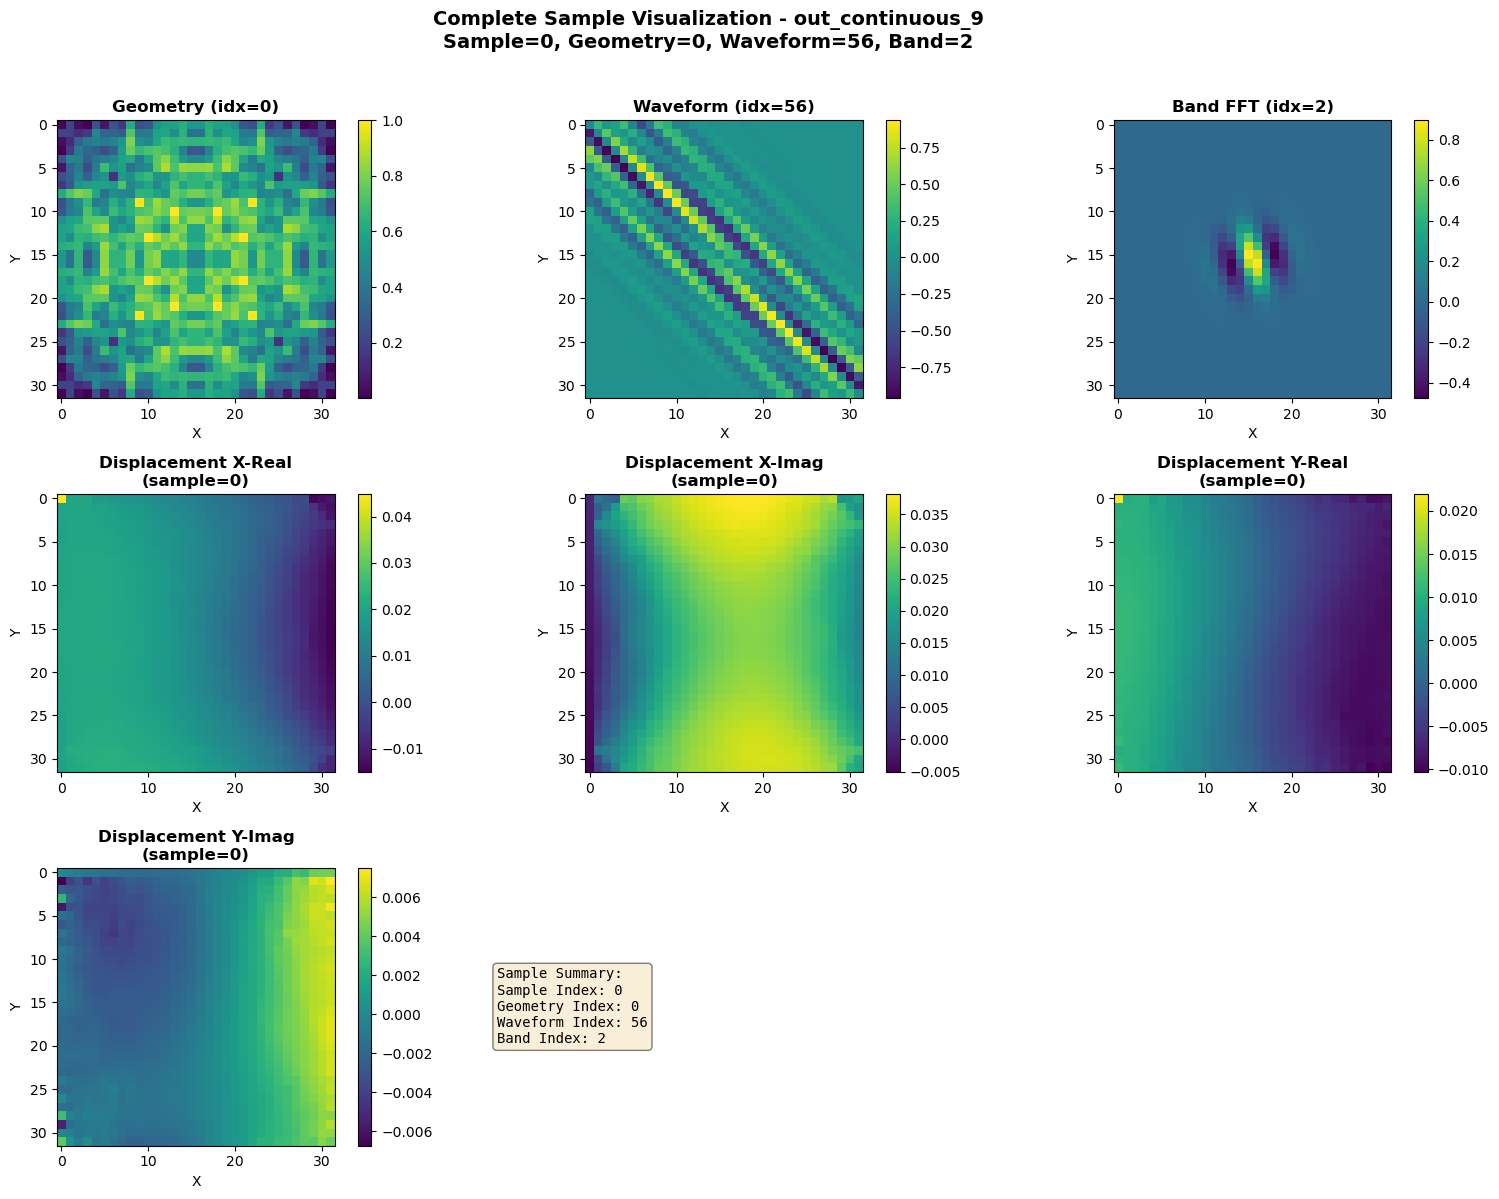


Visualization complete!
Dataset: out_continuous_9
Sample 0 uses:
  - Geometry index: 0
  - Waveform index: 56
  - Band index: 2
  - Displacement components: x_real, x_imag, y_real, y_imag


In [62]:
if len(converted_datasets) > 0:
    # Select which dataset to visualize (last one by default, or specify by index)
    dataset_to_visualize = -1  # -1 = last converted dataset, or set to index like 0, 1, 2...
    
    if abs(dataset_to_visualize) >= len(converted_datasets):
        dataset_to_visualize = -1
    
    selected_dataset = converted_datasets[dataset_to_visualize]
    visualize_output_path = selected_dataset['output_path']
    
    print("=" * 80)
    print("Visualizing Complete Sample")
    print("=" * 80)
    print(f"Dataset: {selected_dataset['file_name']}")
    print(f"Location: {visualize_output_path}")
    
    # Load the saved dataset
    print("\nLoading saved dataset...")
    loaded_displacements = torch.load(visualize_output_path / "displacements_dataset.pt", map_location='cpu')
    loaded_indices = torch.load(visualize_output_path / "reduced_indices.pt", map_location='cpu')
    loaded_geometries = torch.load(visualize_output_path / "geometries_full.pt", map_location='cpu')
    loaded_waveforms = torch.load(visualize_output_path / "waveforms_full.pt", map_location='cpu')
    loaded_bands = torch.load(visualize_output_path / "band_fft_full.pt", map_location='cpu')
    
    # Select a sample to visualize
    sample_idx = 0
    print(f"\nVisualizing sample index: {sample_idx}")
    
    # Get the mapping indices for this sample
    geom_idx, waveform_idx, band_idx = loaded_indices[sample_idx]
    
    print(f"Sample mapping:")
    print(f"  Sample index: {sample_idx}")
    print(f"  Geometry index: {geom_idx}")
    print(f"  Waveform index: {waveform_idx}")
    print(f"  Band index: {band_idx}")
    
    # Extract the data for this sample
    geometry = loaded_geometries[geom_idx].cpu().numpy()
    waveform = loaded_waveforms[waveform_idx].cpu().numpy()
    band = loaded_bands[band_idx].cpu().numpy()
    
    # Extract the 4 displacement components
    disp_x_real = loaded_displacements.tensors[0][sample_idx].cpu().numpy()
    disp_x_imag = loaded_displacements.tensors[1][sample_idx].cpu().numpy()
    disp_y_real = loaded_displacements.tensors[2][sample_idx].cpu().numpy()
    disp_y_imag = loaded_displacements.tensors[3][sample_idx].cpu().numpy()
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(16, 12))
    
    # Input components (top row)
    ax1 = plt.subplot(3, 3, 1)
    im1 = ax1.imshow(geometry, cmap='viridis')
    ax1.set_title(f'Geometry (idx={geom_idx})', fontsize=12, fontweight='bold')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    
    ax2 = plt.subplot(3, 3, 2)
    im2 = ax2.imshow(waveform, cmap='viridis')
    ax2.set_title(f'Waveform (idx={waveform_idx})', fontsize=12, fontweight='bold')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    
    ax3 = plt.subplot(3, 3, 3)
    im3 = ax3.imshow(band, cmap='viridis')
    ax3.set_title(f'Band FFT (idx={band_idx})', fontsize=12, fontweight='bold')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im3, ax=ax3, fraction=0.046)
    
    # Displacement components (bottom 2 rows)
    ax4 = plt.subplot(3, 3, 4)
    im4 = ax4.imshow(disp_x_real, cmap='viridis')
    ax4.set_title(f'Displacement X-Real\n(sample={sample_idx})', fontsize=12, fontweight='bold')
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    plt.colorbar(im4, ax=ax4, fraction=0.046)
    
    ax5 = plt.subplot(3, 3, 5)
    im5 = ax5.imshow(disp_x_imag, cmap='viridis')
    ax5.set_title(f'Displacement X-Imag\n(sample={sample_idx})', fontsize=12, fontweight='bold')
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')
    plt.colorbar(im5, ax=ax5, fraction=0.046)
    
    ax6 = plt.subplot(3, 3, 6)
    im6 = ax6.imshow(disp_y_real, cmap='viridis')
    ax6.set_title(f'Displacement Y-Real\n(sample={sample_idx})', fontsize=12, fontweight='bold')
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')
    plt.colorbar(im6, ax=ax6, fraction=0.046)
    
    ax7 = plt.subplot(3, 3, 7)
    im7 = ax7.imshow(disp_y_imag, cmap='viridis')
    ax7.set_title(f'Displacement Y-Imag\n(sample={sample_idx})', fontsize=12, fontweight='bold')
    ax7.set_xlabel('X')
    ax7.set_ylabel('Y')
    plt.colorbar(im7, ax=ax7, fraction=0.046)
    
    # Add summary text in the last subplot
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('off')
    summary_text = f"""Sample Summary:
Sample Index: {sample_idx}
Geometry Index: {geom_idx}
Waveform Index: {waveform_idx}
Band Index: {band_idx}"""
    ax8.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center', 
             family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Remove the last empty subplot
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Overall title
    fig.suptitle(f'Complete Sample Visualization - {selected_dataset["file_name"]}\nSample={sample_idx}, Geometry={geom_idx}, Waveform={waveform_idx}, Band={band_idx}', 
                 fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
    print(f"\nVisualization complete!")
    print(f"Dataset: {selected_dataset['file_name']}")
    print(f"Sample {sample_idx} uses:")
    print(f"  - Geometry index: {geom_idx}")
    print(f"  - Waveform index: {waveform_idx}")
    print(f"  - Band index: {band_idx}")
    print(f"  - Displacement components: x_real, x_imag, y_real, y_imag")
else:
    print("No datasets were successfully converted. Visualization skipped.")


---

**Note:** The conversion process (Steps 1-5) is now handled automatically by the `convert_matlab_to_reduced_pt()` function for each file. The cells below (previously Steps 4-7) have been removed as they were redundant with the function's internal processing.

If you need to inspect or verify a specific converted dataset, use the visualization cell above or load the saved files directly.


## Verification (Optional)

Verify a specific converted dataset can be loaded correctly:


In [30]:
if len(converted_datasets) > 0:
    # Select which dataset to verify (last one by default)
    dataset_to_verify = -1
    
    if abs(dataset_to_verify) >= len(converted_datasets):
        dataset_to_verify = -1
    
    selected_dataset = converted_datasets[dataset_to_verify]
    verify_output_path = selected_dataset['output_path']
    
    print("=" * 80)
    print("Verification")
    print("=" * 80)
    print(f"Verifying dataset: {selected_dataset['file_name']}")
    print(f"Location: {verify_output_path}")
    
    # Load the saved dataset to verify
    print("\nLoading saved dataset for verification...")
    verify_displacements = torch.load(verify_output_path / "displacements_dataset.pt", map_location='cpu')
    verify_indices = torch.load(verify_output_path / "reduced_indices.pt", map_location='cpu')
    verify_geometries = torch.load(verify_output_path / "geometries_full.pt", map_location='cpu')
    verify_waveforms = torch.load(verify_output_path / "waveforms_full.pt", map_location='cpu')
    verify_wavevectors = torch.load(verify_output_path / "wavevectors_full.pt", map_location='cpu')
    verify_bands = torch.load(verify_output_path / "band_fft_full.pt", map_location='cpu')
    verify_design_params = torch.load(verify_output_path / "design_params_full.pt", map_location='cpu')
    
    print("\nVerified Loaded Shapes:")
    print(f"  displacements_dataset: {len(verify_displacements)} tensors")
    for i, tensor in enumerate(verify_displacements.tensors):
        print(f"    tensor[{i}]: {tensor.shape}, dtype: {tensor.dtype}")
    print(f"  reduced_indices: {len(verify_indices)} tuples")
    print(f"  geometries_full: {verify_geometries.shape}, dtype: {verify_geometries.dtype}")
    print(f"  waveforms_full: {verify_waveforms.shape}, dtype: {verify_waveforms.dtype}")
    print(f"  wavevectors_full: {verify_wavevectors.shape}, dtype: {verify_wavevectors.dtype}")
    print(f"  band_fft_full: {verify_bands.shape}, dtype: {verify_bands.dtype}")
    print(f"  design_params_full: {verify_design_params.shape}, dtype: {verify_design_params.dtype}")
    
    # Verify data integrity
    print("\nData Integrity Checks:")
    print(f"  ✓ All files loaded successfully")
    print(f"  ✓ Displacement tensors match: {len(verify_displacements.tensors) == 4}")
    print(f"  ✓ Reduced indices count: {len(verify_indices)}")
    print(f"  ✓ Sample index tuple format: {type(verify_indices[0]) == tuple and len(verify_indices[0]) == 3}")
    
    # Show sample mapping
    sample_idx = 0
    geom_idx, wv_idx, band_idx = verify_indices[sample_idx]
    print(f"\nSample {sample_idx} mapping:")
    print(f"  Geometry index: {geom_idx}")
    print(f"  Waveform index: {wv_idx}")
    print(f"  Band index: {band_idx}")
    print(f"  Corresponding geometry shape: {verify_geometries[geom_idx].shape}")
    print(f"  Corresponding waveform shape: {verify_waveforms[wv_idx].shape}")
    print(f"  Corresponding band shape: {verify_bands[band_idx].shape}")
    
    print("\n" + "=" * 80)
    print(f"Verification Complete for {selected_dataset['file_name']}!")
    print("=" * 80)
    print(f"Reduced dataset saved to: {verify_output_path}")
    print(f"Ready for neural operator training!")
else:
    print("No datasets were successfully converted. Verification skipped.")


Verification
Verifying dataset: out_continuous_9
Location: D:\Research\NO-2D-Metamaterials\data_debug\train\out_continuous_9

Loading saved dataset for verification...


C:\Users\hz283\AppData\Local\Temp\ipykernel_93892\1674940425.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  verify_displacements = torch.load(verify_output_path / "dis


Verified Loaded Shapes:
  displacements_dataset: 81900 tensors
    tensor[0]: torch.Size([81900, 32, 32]), dtype: torch.float16
    tensor[1]: torch.Size([81900, 32, 32]), dtype: torch.float16
    tensor[2]: torch.Size([81900, 32, 32]), dtype: torch.float16
    tensor[3]: torch.Size([81900, 32, 32]), dtype: torch.float16
  reduced_indices: 81900 tuples
  geometries_full: torch.Size([150, 32, 32]), dtype: torch.float16
  waveforms_full: torch.Size([91, 32, 32]), dtype: torch.float16
  wavevectors_full: torch.Size([150, 91, 2]), dtype: torch.float16
  band_fft_full: torch.Size([6, 32, 32]), dtype: torch.float16
  design_params_full: torch.Size([1, 6]), dtype: torch.float16

Data Integrity Checks:
  ✓ All files loaded successfully
  ✓ Displacement tensors match: True
  ✓ Reduced indices count: 81900
  ✓ Sample index tuple format: True

Sample 0 mapping:
  Geometry index: 0
  Waveform index: 10
  Band index: 0
  Corresponding geometry shape: torch.Size([32, 32])
  Corresponding waveform s

C:\Users\hz283\AppData\Local\Temp\ipykernel_93892\1674940425.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  verify_waveforms = torch.load(verify_output_path / "wavefor